<a href="https://colab.research.google.com/github/helenmcain/EHR-Exploratory-Data-Analysis/blob/main/5010_final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Project: Examining Hospital Surgery Data

Helen Cain

DS-5010

Northeastern University
    
Maryam Farahmand, Phd.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Avoids scroll-in-the-scroll in the entire Notebook
from IPython.display import Javascript
def resize_colab_cell():
  display(Javascript('google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'))
get_ipython().events.register('pre_run_cell', resize_colab_cell)

# About this Dataset

MOVER, or [Medical Informatatics Operation Room Vitals and Events Repository](https://mover.ics.uci.edu/documentation.html), is a data repository associated with Univeristy of California, Irvine Medical Center. The dataset compiles the EPIC medical charts of all patients who underwent surgery at the hospital from the years 2017-2022. Due to the size of the repository, it has been split into multiple .csv files, which cover everything from patient demographic information, to medical history, medications, lines and drains administered during surgery, and post-operative complications. For the sake of this project, I will select relevant variables throughout multiple files to combine together, and see which insights I can glean from them.

In [4]:
info = pd.read_csv('/content/drive/MyDrive/EPIC_EMR/EMR/patient_information.csv')

<IPython.core.display.Javascript object>

The above DataFrame, which we will call "info", contains basic information about each surgery, and will be used as the "base" Dataframe in our investigation. Each entry represents one surgical procedure performed between 2017 and 2022.

In [5]:
# rename columns
info.rename(columns={'LOG_ID': 'log_id', 'MRN':'mrn', 'SURGERY_DATE': 'surgery_date',
                     'HEIGHT': 'height_ft_in', 'WEIGHT': 'weight_oz', 'SEX' : 'sex',
                     'HOSP_ADMSN_TIME': 'hospital_admission', "HOSP_DISCH_TIME": 'hospital_discharge',
                     'LOS': "length_of_stay_days", 'ICU_ADMIN_FLAG': "icu_admit", "BIRTH_DATE": 'age',
                    "ASA_RATING_C": 'asa_rating',
                     "PATIENT_CLASS_GROUP": "in_outpatient", "PRIMARY_PROCEDURE_NM": "primary_procedure",
                     "IN_OR_DTTM": 'procedure_start',
                     "OUT_OR_DTTM": 'procedure_end'}, inplace=True)

# convert time-series data
info[['surgery_date', 'hospital_admission', 'hospital_discharge', 'procedure_start',
'procedure_end']] = info[['surgery_date', 'hospital_admission', 'hospital_discharge', 'procedure_start',
'procedure_end']].apply(lambda x: pd.to_datetime(x, format = '%m/%d/%y %H:%M'))

# drop redundant columns and duplicate entries
info.drop(columns= ['DISCH_DISP_C', 'DISCH_DISP', 'ASA_RATING', 'PATIENT_CLASS_NM',
                    "AN_START_DATETIME", "AN_STOP_DATETIME", 'PRIMARY_ANES_TYPE_NM'], inplace=True)
info.drop_duplicates(inplace=True)

info.info()

<IPython.core.display.Javascript object>

<class 'pandas.core.frame.DataFrame'>
Index: 64360 entries, 0 to 65727
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   log_id               64360 non-null  object        
 1   mrn                  64360 non-null  object        
 2   hospital_admission   64360 non-null  datetime64[ns]
 3   hospital_discharge   64346 non-null  datetime64[ns]
 4   length_of_stay_days  64346 non-null  float64       
 5   icu_admit            64360 non-null  object        
 6   surgery_date         64360 non-null  datetime64[ns]
 7   age                  64360 non-null  int64         
 8   height_ft_in         51634 non-null  object        
 9   weight_oz            61997 non-null  float64       
 10  sex                  64360 non-null  object        
 11  asa_rating           57549 non-null  float64       
 12  in_outpatient        64360 non-null  object        
 13  primary_procedure    64354 non-null 

A brief description of each variable:

*   log_id: code representing each unique surgery or procedure
*   mrn: code representing each unique patient

**NOTE:** a single patient who had multiple procedures within the time frame will appear as multiple entries with duplicate MRNs, but unique log ids



*   Hospital admission/discharge: date and time that a patient was admitted to/discharged from the hospital
*   Length of stay: total time in the hospital in days
*   ICU admit: whether or not a patient was admitted to the ICU
*   Surgery date
*   Age in years
*   Height in feet and inches
*   Weight in ounces
*   Sex (male/female)
*   In/Outpatient: Was the surgery inpatient or outpatient?
*   Procedure start/end: The exact date and time that the patient entered and left the OR
* Primary Procedure: name of the procedure the patient recieved
* ASA rating: ASA physical status classification system that determines the fitness of a patient for surgery













In [ ]:
labs = pd.read_csv('/content/drive/MyDrive/EPIC_EMR/EMR/patient_labs.csv', usecols=['MRN', 'LOG_ID', 'Abnormal Flag'])
labs.dropna(inplace=True)
labs.rename(columns={'MRN': 'mrn', 'LOG_ID': 'log_id', 'Abnormal Flag':'abnormal_result'}, inplace=True)
labs.head()

The "labs" dataframe has an entry for each laboratory test a patient recieved. The "abnormal result" column designates whether a patient's test results were within normal range.

N = negative/normal

L = low

H = high

LL/HH = critically low or critically high

In [6]:
visit = pd.read_csv('/content/drive/MyDrive/EPIC_EMR/EMR/patient_visit.csv')
visit.rename(columns={"LOG_ID": "log_id"}, inplace=True)
visit.drop_duplicates(keep='first', inplace=True)
visit.head()

<IPython.core.display.Javascript object>

,log_id,mrn,diagnosis_code,dx_name
0,eea6541676c81622,65627c5e4d878b1e,009.3,Diarrhea of presumed infectious origin
4,a19e032b366b5aff,31c7591554d5a5e5,112.81,Candidal endocarditis
6,2430798b32f71a88,71b5a575fd4b7e0e,133.0,Scabies
7,2effa1961b4191cb,27aa49dc4b87cd55,142.1,Malignant neoplasm of submandibular gland (CMS...
8,15590909307ee37e,bf7c0beb41e0cc4a,145.6,Malignant neoplasm of retromolar area (CMS-HCC)


The "visit" dataset represents diagnoses that patients recieved while at the hospital.

* Diagnosis code: the ICD-9 diagnosis code for the condition

* DX name: the name of the condition

I also used a "medications" dataset, where each entry represents a precription that a patient recieved. Due to the size of the dataset, I had to open and process it seperately.

All of these files use different indexing systems, which makes it difficult to get a clear picture of each procedure or patient who went through the hospital. Throughout this project, I will look for relationships between variables, and build out a "patients" dataset that combines elements of each of these datasets together to provide more holistic "patient profiles" of those who recieve treatment.

## Question 1:
pandas

What were the top five procedures for female patients? For male patients?

In [7]:
female = info[info['sex'] == 'Female']
male = info[info['sex'] == 'Male']

female_procedures = female.groupby('primary_procedure').size().sort_values(ascending=False)
male_procedures = male.groupby('primary_procedure').size().sort_values(ascending=False)

display(female_procedures.head())
display(male_procedures.head())

<IPython.core.display.Javascript object>

,0
primary_procedure,
"DILATION AND EVACUATION, UTERUS",886
"CHOLECYSTECTOMY, LAPAROSCOPIC",785
"LAPAROSCOPY, DIAGNOSTIC",618
"CATHETERIZATION, HEART, LEFT, WITH INTERVENTION IF INDICATED",517
"HYSTERECTOMY, TOTAL, ABDOMINAL, ROBOT-ASSISTED, LAPAROSCOPIC, WITH BSO",508


,0
primary_procedure,
"CATHETERIZATION, HEART, LEFT, WITH INTERVENTION IF INDICATED",1004
"LAPAROTOMY, EXPLORATORY",549
"DEBRIDEMENT, WITH SPLIT-THICKNESS SKIN GRAFT APPLICATION",492
"DA VINCI XI- PROSTATECTOMY, RADICAL, ROBOT-ASSISTED",444
"IRRIGATION AND DEBRIDEMENT, LOWER EXTREMITY",426


## Question 2:
pandas, matplotlib, seaborn

What time of day is the busiest? Plot a line plot of when during the day surgeries begin and end.

<IPython.core.display.Javascript object>

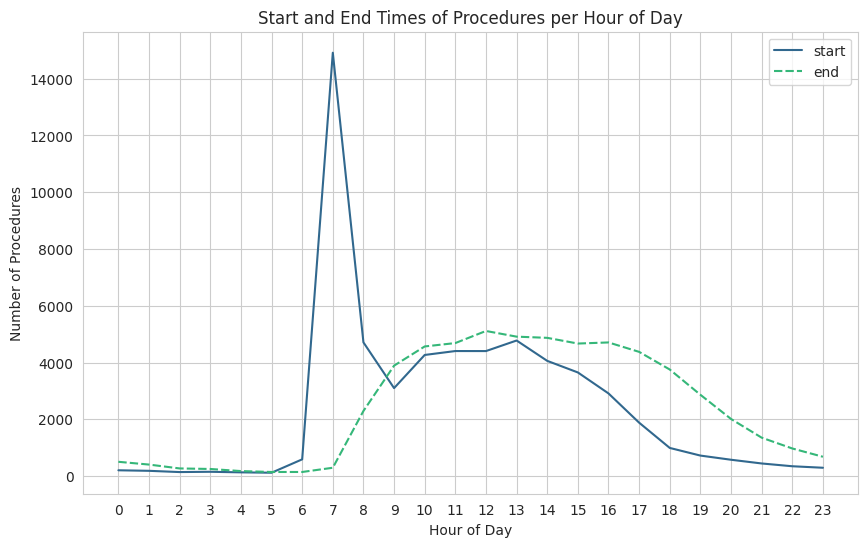

In [8]:
start = info.groupby(info['procedure_start'].dt.hour)['log_id'].count().to_frame()
end = info.groupby(info['procedure_end'].dt.hour)['log_id'].count().to_frame()

day = pd.concat([start, end], axis=1)
day.columns = ['start', 'end']

plt.figure(figsize=(10, 6))
sns.set_style('whitegrid')
sns.lineplot(data=day[['start', 'end']], palette='viridis')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Procedures')
plt.title('Start and End Times of Procedures per Hour of Day')
plt.xticks(np.arange(0, 24, 1))
plt.show()

## Question 3:
pandas, matplotlib, seaborn

Is there a seasonal pattern to the average number of surgeries per month?

In [9]:
year_months = info.groupby([info['surgery_date'].dt.year, info['surgery_date'].dt.month])['log_id'].count().to_frame()
months = year_months.groupby(level=1).mean()
display(months)

<IPython.core.display.Javascript object>

,log_id
surgery_date,
1,928.500000
2,840.333333
3,919.000000
4,883.166667
5,920.333333
6,866.166667
7,909.500000
8,925.000000
9,1046.600000


<IPython.core.display.Javascript object>

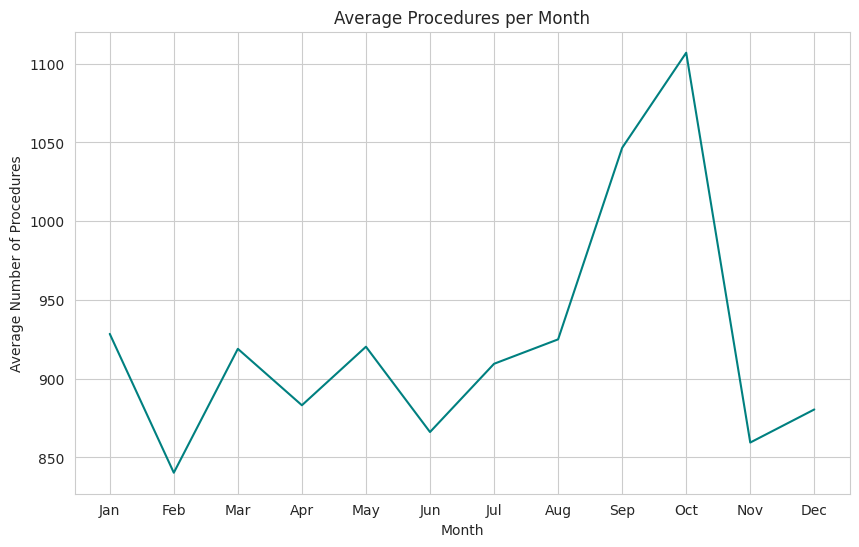

In [10]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.lineplot(data=months, x=months.index, y='log_id', ax=ax, color='teal')
ax.set_xlabel('Month')
ax.set_ylabel('Average Number of Procedures')
ax.set_title('Average Procedures per Month')
ax.set_xticks(np.arange(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

There was a spike in the number of procedures performed in the months of September and October.

## Question 4:
pandas, numpy

Which procedures take the longest, on average? The shortest?

1. Create a "surgery length" column to represent how long each procedure lasts.

2. Filter out any procedures with less than thirty instances.

3. Find the z-scores of the fastest and shortest surgeries.


In [11]:
time = info[['log_id', 'primary_procedure', 'procedure_start', 'procedure_end']].copy()
time.dropna(subset=['procedure_start', 'procedure_end'], inplace=True)
info['surgery_length'] = time['procedure_end'] - time['procedure_start']
time_group = info.groupby('primary_procedure')['surgery_length'].agg(['mean', 'count']).sort_values(by='mean', ascending=False)
display(time_group.head())

<IPython.core.display.Javascript object>

,mean,count
primary_procedure,,
"MAXILLECTOMY, WITH ORBITAL EXENTERATION",0 days 17:10:00,1
"FUSION, SPINE, THORACIC, ANTERIOR APPROACH",0 days 16:30:00,1
"CREATION, BYPASS, ARTERIAL, AORTA TO FEMORAL",0 days 15:00:00,1
"VAGINECTOMY, TOTAL",0 days 14:53:00,1
"BREAST RECONSTRUCTION, WITH FREE FLAP",0 days 13:32:24,30


In [12]:
# filter out procedures performed less than thirty times.
time_30 = time_group[time_group['count'] >= 30]
display(time_30)

<IPython.core.display.Javascript object>

,mean,count
primary_procedure,,
"BREAST RECONSTRUCTION, WITH FREE FLAP",0 days 13:32:24,30
WHIPPLE PROCEDURE,0 days 10:25:38.936170212,94
"WHIPPLE PROCEDURE, LAPAROSCOPIC",0 days 10:19:57.798165137,109
"FREE FLAP, LOWER EXTREMITY, WITH MICROVASCULAR ANASTOMOSIS",0 days 10:15:11.351351351,37
"HIPEC - CHEMOTHERAPY, INTRAPERITONEAL, HYPERTHERMIC",0 days 09:50:22.500000,56
...,...,...
IR US BIOPSY RENAL,0 days 01:03:08.571428571,35
"MANIPULATION, JOINT",0 days 01:00:10,30
IR PARACENTESIS,0 days 00:59:46.153846153,39


In [13]:
mean = np.mean(time_30['mean'])
std = np.std(time_30['mean'])
z_scores = (time_30['mean'] - mean) / std

print(f"The average length of procedures was {mean.round('s')}")
print(f"The standard deviation of procedure lengths was {std.round('s')}")
print(f"The longest average procedure is {z_scores.iloc[0]: .2f} standard devations from the mean")
print(f"The shortest average procedure is {z_scores.iloc[-1]: .2f} standard deviations from the mean")

<IPython.core.display.Javascript object>

The average length of procedures was 0 days 03:32:30
The standard deviation of procedure lengths was 0 days 01:52:17
The longest average procedure is  5.34 standard devations from the mean
The shortest average procedure is -1.58 standard deviations from the mean


## Question 5
pandas, lambda function, matplotlib, seaborn

Propofol is the most commonly used IV general anesthetic. Is there a relationship between weight and Propofol dosage?

1. Due to the size of the medication section of the dataset, I had to process it in a separate Jupyter Notebook: [link](https://colab.research.google.com/drive/13L5j6p33vfiS1wLiJSHuTqL94vS3qaD0#scrollTo=_epv8ej0Q-0Q). I created a dataset called 'propfol.csv' with columns for MRN, LOG ID, and the dosage of propofol per procedure.

2. Create a new dataset for patients prescribed propofol by merging with the 'propofol.csv' dataset.

3. Use a lambda function to convert the weight column from ounces to kilograms.

4. Convert propofol dosage from micrograms/kilogram/minute to microgram/minute.

5. Plot the relationship with a scatterplot.

<IPython.core.display.Javascript object>

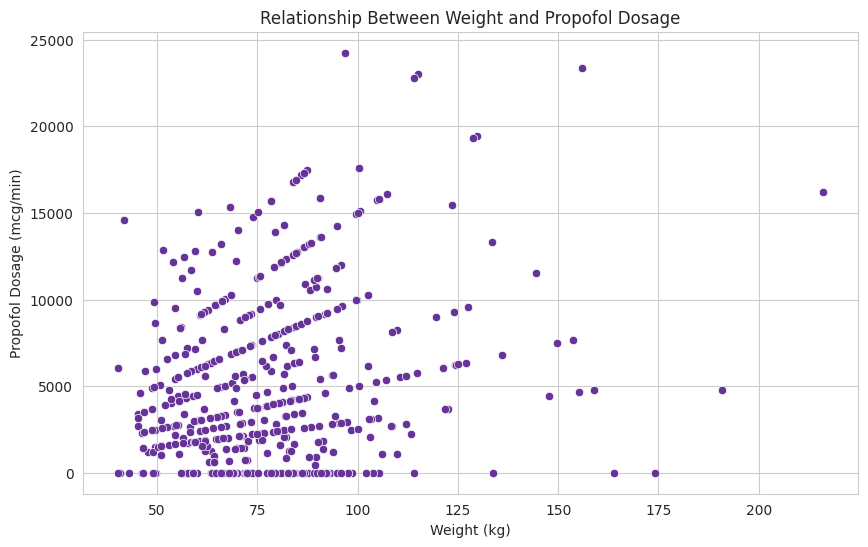

In [14]:
# merge datasets
propo = pd.read_csv('/content/drive/MyDrive/EPIC_EMR/EMR/propofol.csv')
propo.reset_index()
propo_patients = pd.merge(info, propo, on=['log_id'], how='inner')

# convert weight column
propo_patients['weight_oz'] = propo_patients['weight_oz'].apply(lambda x: x / 35.274)
propo_patients.rename(columns={'weight_oz': 'weight_kg'}, inplace=True)

#convert dosage column
propo_patients['propofol_dosage'] = propo_patients['propofol_dosage'] * propo_patients['weight_kg']

# scatter plot
fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(data=propo_patients.sample(500), x='weight_kg', y='propofol_dosage', color='rebeccapurple')
plt.title('Relationship Between Weight and Propofol Dosage')
plt.xlabel('Weight (kg)')
plt.ylabel('Propofol Dosage (mcg/min)')
plt.show()

## Question 6
defined function, pandas, matplotlib, seaborn

Does the percentage of patients admitted to the ICU change with age?

1. Define a function for calculating the percentage of patients admitted to the ICU by age.
2. Plot the relationship using a line plot

In [15]:
icu_age = info[['mrn', 'age', 'icu_admit', 'hospital_admission']].copy()
icu_age.drop_duplicates(subset=['mrn', 'hospital_admission'], keep='first', inplace=True)
icu_age.dropna(subset=['age', 'icu_admit'], inplace=True)

def percentage_by_group(df, group_col, target_col, target_value):
  '''Creates a DataFrame that groups on a specified column and calculates percentages that fit a target value

    Parameters:
    df: the source DataFrame
    group_col: the column to have .groupby applied to for the new DataFrame
    target_col: the column designated for percent calculations
    target_value: resulting DataFrame will specify the percentage of entries that match this value'''
  total_df = df.groupby(group_col).size()
  count_df = df[df[target_col] == target_value].groupby(group_col).size()
  percentage_df = pd.merge(total_df.rename('total_count'), count_df.rename(f'{target_value}_count'), on=group_col)
  percentage_df[f'{target_value}_percent'] = percentage_df[f'{target_value}_count'] / percentage_df['total_count'] * 100
  return percentage_df

icu_percent = percentage_by_group(icu_age, 'age', 'icu_admit', 'Yes')
icu_percent.rename(columns={'Yes_count': 'icu_count', 'Yes_percent': 'percent_in_icu'}, inplace=True)
display(icu_percent)

<IPython.core.display.Javascript object>

,total_count,icu_count,percent_in_icu
age,,,
17,25,14,56.000000
18,170,55,32.352941
19,260,86,33.076923
20,331,113,34.138973
21,352,100,28.409091
...,...,...,...
86,302,124,41.059603
87,223,79,35.426009
88,190,84,44.210526


<IPython.core.display.Javascript object>

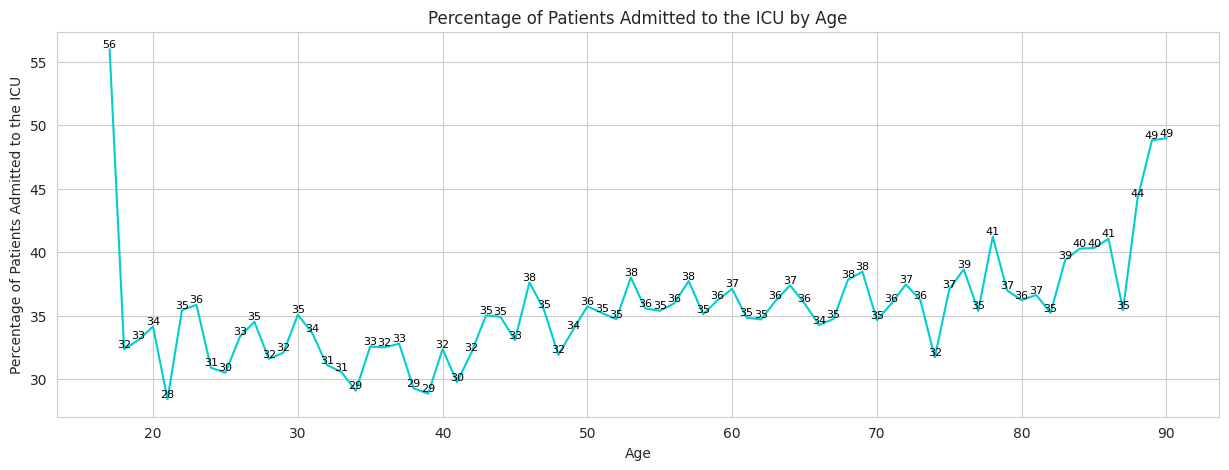

In [16]:
icu_percent.reset_index(inplace=True)
fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(data=icu_percent, x='age', y='percent_in_icu', color='darkturquoise')
ax.set_title('Percentage of Patients Admitted to the ICU by Age')
ax.set_xlabel('Age')
ax.set_ylabel('Percentage of Patients Admitted to the ICU')

for index, row in icu_percent.iterrows():
        plt.text(row['age'],
                 row['percent_in_icu'],
                 f'{row["percent_in_icu"]:.0f}',
                 ha = 'center',
                 va = 'bottom',
                 color = 'black',
                 fontsize = 8)
plt.show()

The line plot above shows a slight upward trend in ICU admission rates as patients age. The 56% admit rate for seventeen year-old patients may be due to the fact that those under 18 are mostly treated in children's hospitals. The presence of a minor in an adult hospital could indicate a more complex procedure or serious illness.

## Question 7:
pandas, matplotlib, lambda functions

What proportion of patients fall under each ASA classification?

In [17]:
asa = info[['mrn', 'log_id', 'asa_rating']].copy()
asa.dropna(subset=['asa_rating'], inplace=True)
# avoid double counting patients who had multiple surgeries over the same stay
asa.drop_duplicates(keep='first', inplace=True)
asa_pie=asa['asa_rating'].value_counts(normalize=True).sort_index()
asa_pie_percent = asa_pie.apply(lambda x: f'{x * 100:.2f}%')
display(asa_pie_percent)

<IPython.core.display.Javascript object>

,proportion
asa_rating,
1.0,5.14%
2.0,31.40%
3.0,51.17%
4.0,11.07%
5.0,1.14%
6.0,0.07%


<IPython.core.display.Javascript object>

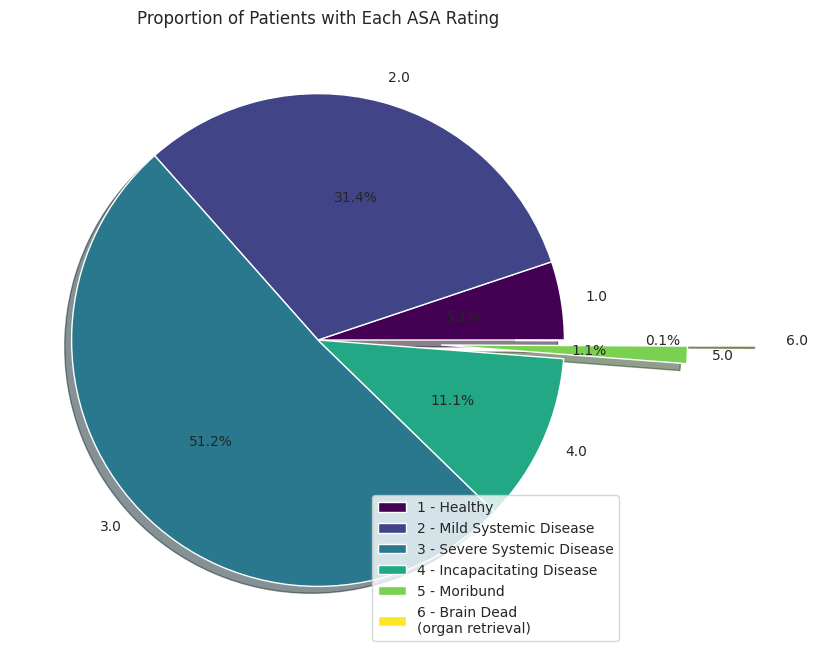

In [18]:
plt.figure(figsize=(8, 8))
explode = [0, 0, 0, 0, 0.5, 0.8]
asa_pie.plot(kind='pie', cmap='viridis', explode=explode, autopct='%1.1f%%', shadow=True)
plt.title('Proportion of Patients with Each ASA Rating')
plt.ylabel('')
plt.legend(labels=['1 - Healthy', '2 - Mild Systemic Disease', '3 - Severe Systemic Disease',
               '4 - Incapacitating Disease', '5 - Moribund', '6 - Brain Dead \n(organ retrieval)'], loc='lower right')
plt.show()

## Question 8:

How does the distribution of ASA labels change with age?
1. Bin patient data by age group
2. Use a stacked bar plot to visualize the the count of various ASA ratings by age group


<IPython.core.display.Javascript object>

,,age,asa_rating,age_bin
mrn,log_id,,,
2e92522a5f2a2a22,cd1636c6279d73a0,47,3.0,45-65
b7a91e623d957d8f,fc53c06ee2cfe438,81,3.0,66+
b68d6c7198f30f73,2f0090c47da34608,49,2.0,45-65
46aa48e89b9c50e8,6d3b621880c6ced4,54,2.0,45-65
c2756216cc89b795,82f89e10f2855420,44,2.0,25-44
...,...,...,...,...
aecf54e7e0077c0b,b619db184a3f7d86,65,3.0,45-65
cd3f8576771bf9d2,54b5138bdecfd66f,48,2.0,45-65
50b9fdfb13f2d8ec,35d4b39cdc9525ee,62,3.0,45-65


asa_rating,1.0,2.0,3.0,4.0,5.0,6.0
age_bin,,,,,,
Under 25,706,1159,720,216,49,5
25-44,1627,6305,5137,1073,157,13
45-65,572,7129,12278,2531,252,20
66+,55,3475,11315,2553,199,3


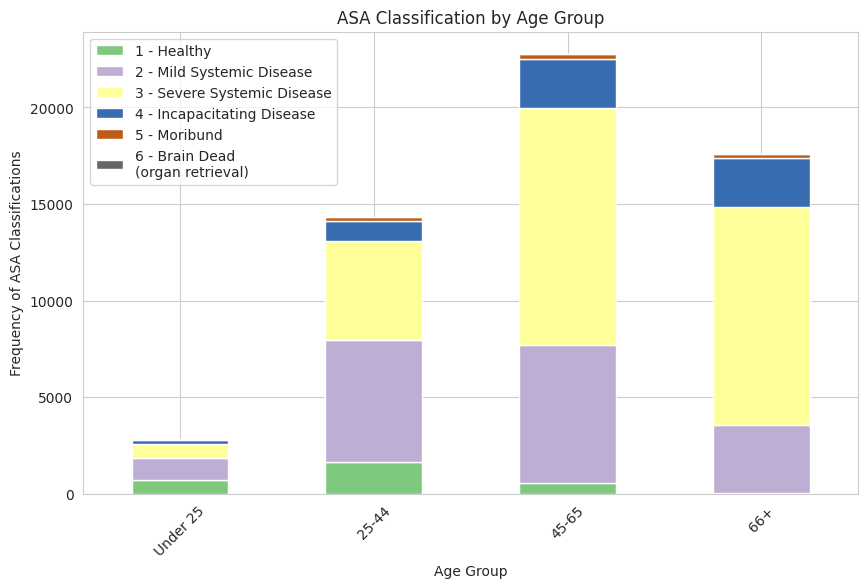

In [19]:
info.reset_index(inplace=True)
asa_age = info[['mrn', 'log_id', 'age', 'asa_rating']].copy()
asa_age.set_index(['mrn', 'log_id'], inplace=True)
asa_age.dropna(subset=['asa_rating', 'age'], inplace=True)

bins = [0, 25, 45, 66, np.inf]
labels = ["Under 25", "25-44", "45-65", "66+"]
asa_age['age_bin'] = pd.cut(asa_age['age'], bins=bins, labels=labels, right=False)

display(asa_age)

proportions = asa_age.groupby(['age_bin', 'asa_rating'], as_index=False).count()

pivot = proportions.pivot(index='age_bin', columns='asa_rating', values='age')
display(pivot)

fig, ax = plt.subplots(figsize=(10, 6))
pivot.plot(kind='bar', stacked=True, ax=ax, cmap='Accent')
ax.set_title('ASA Classification by Age Group')
plt.legend(labels=['1 - Healthy', '2 - Mild Systemic Disease', '3 - Severe Systemic Disease',
               '4 - Incapacitating Disease', '5 - Moribund', '6 - Brain Dead \n(organ retrieval)'])
ax.set_xlabel('Age Group')
ax.tick_params(axis='x', labelrotation=45)
ax.set_ylabel('Frequency of ASA Classifications')
plt.show()


The proportion of patients with severe systemic disease or in moribund condition appears to increase with age.

## Question 9:
pandas, numpy, matplotlib, seaborn

What is the distribution of the number of procedures per patient?

1. Begin construction of the "patients" dataset.

2. Use numpy to show summary statistics, including mean, median, and maxiumum.

3. Plot a histogram with matplotlib and seaborn



In [20]:
# new dataset including mrn and total procedures per patient
patients = info.groupby('mrn')['log_id'].count().to_frame()
patients.rename(columns={'log_id': 'procedures_count'}, inplace=True)
display(patients.sort_values(by='procedures_count', ascending=False))

<IPython.core.display.Javascript object>

,procedures_count
mrn,
1bb09d5761661c7d,41
cd955ec437f44536,34
e43f3b4bcb161d8a,27
6045da125483b436,27
b36a44c0b49c1226,27
...,...
001db4cccda5b5ac,1
001aa360cbec0920,1
0019190760c133b9,1


In [21]:
# summary statistics
print(f'Median number of procedures per patient: {np.median(patients["procedures_count"])}')
print(f'Average number of procedures per patient: {np.mean(patients["procedures_count"])}')
print(f'Maximum number of procedures per patient: {np.max(patients["procedures_count"])}')

<IPython.core.display.Javascript object>

Median number of procedures per patient: 1.0
Average number of procedures per patient: 1.6217714501700895
Maximum number of procedures per patient: 41


<IPython.core.display.Javascript object>

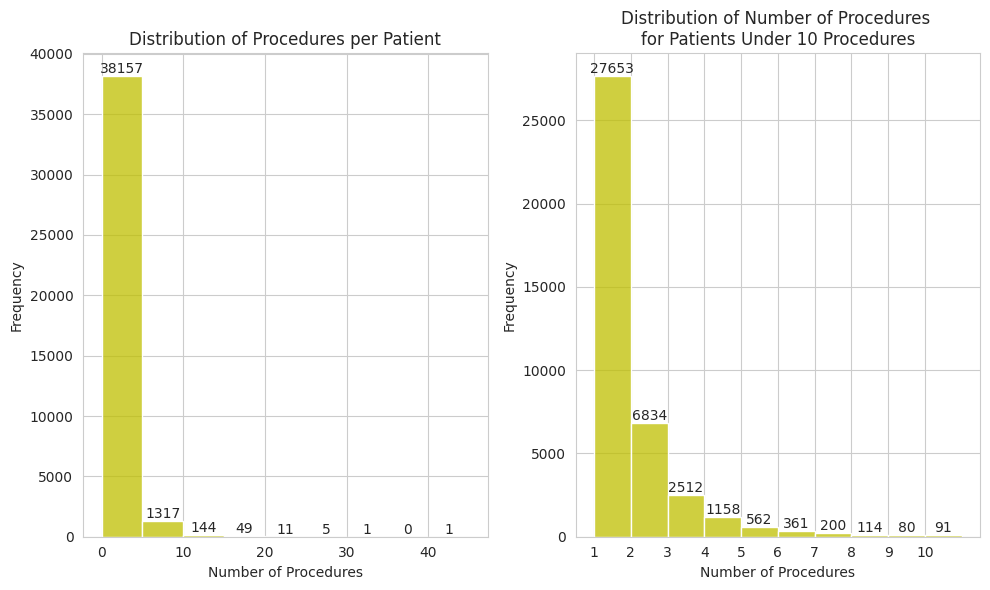

In [22]:
# histogram
fig, ax = plt.subplots(1, 2, figsize=(10, 6))

sns.histplot(data=patients, x='procedures_count', binwidth=5, binrange=(0, 45), color='y',
             ax=ax[0])
ax[0].set_title('Distribution of Procedures per Patient')
ax[0].set_xlabel('Number of Procedures')
ax[0].set_ylabel('Frequency')
bars = ax[0].containers[0]
ax[0].bar_label(bars, labels = [f'{x.get_height()}' for x in bars])

# plot distribution of number of stays for patients with under 10 visits
sns.histplot(data=patients, x='procedures_count', bins=10, binrange=(1, 11), ax=ax[1], color='y')
ax[1].set_title('Distribution of Number of Procedures \nfor Patients Under 10 Procedures')
ax[1].set_xlabel('Number of Procedures')
ax[1].set_ylabel('Frequency')
ax[1].set_xticks(np.linspace(1, 10, 10))
bars = ax[1].containers[0]
ax[1].bar_label(bars, labels = [f'{x.get_height()}' for x in bars])
plt.tight_layout()
fig.show()


plt.show()


The vast majority of patients had under five procedures. One patient had 41 total procedures during the time period, 7 more than the patient with the second most at 34.

## Question 10:
pandas, numpy, matplotlib, seaborn

What is the distribution of the number of hospital visits per patient?

1. Add a new column to the patients dataset representing the number of hospital admissions per patient.

2. Use numpy to show summary statistics, including mean, median, and maxiumum.

3. Plot a histogram with matplotlib and seaborn

In [23]:
# new column
patients['visits_count'] = info.groupby('mrn')['hospital_admission'].nunique()
display(patients.sort_values(by='visits_count', ascending=False))

<IPython.core.display.Javascript object>

,procedures_count,visits_count
mrn,,
1bb09d5761661c7d,41,28
b36a44c0b49c1226,27,24
c61f255b8b424eac,25,23
e4531cd09e428713,22,22
8d4cdd8aff53b098,19,19
...,...,...
ffe4b7d7fa95554d,1,1
ffe039adfdcaddf1,1,1
ffdfe206505636f0,1,1


In [24]:
# display summary statistics
counts = patients['visits_count']
print(f'\nMedian visits: {np.median(counts)}')
print(f'Average visits: {np.mean(counts)}')
print(f'Maximum visits: {np.max(counts)}')

<IPython.core.display.Javascript object>


Median visits: 1.0
Average visits: 1.320120952500945
Maximum visits: 28


<IPython.core.display.Javascript object>

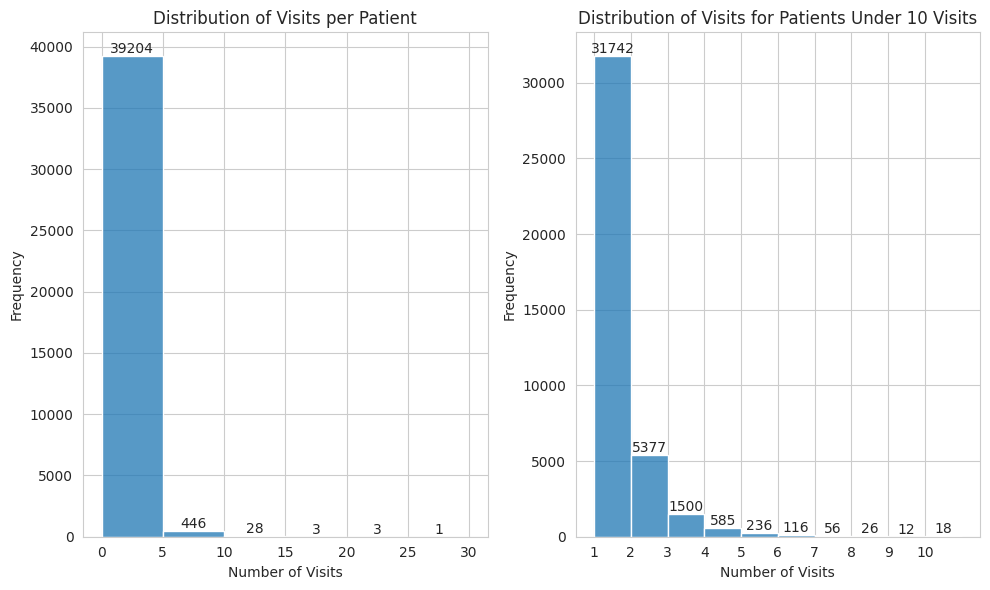

In [25]:
# plot distribution of number of stays by percentage
fig, ax = plt.subplots(1, 2, figsize=(10, 6))

sns.histplot(data=patients, x='visits_count', binwidth=5, binrange=(0, 30), ax=ax[0])
ax[0].set_title('Distribution of Visits per Patient')
ax[0].set_xlabel('Number of Visits')
ax[0].set_ylabel('Frequency')
bars = ax[0].containers[0]
ax[0].bar_label(bars, labels = [f'{x.get_height()}' for x in bars])

# plot distribution of number of stays for patients with under 10 visits
sns.histplot(data=patients, x='visits_count', bins=10, binrange=(1, 11), ax=ax[1])
ax[1].set_title('Distribution of Visits for Patients Under 10 Visits')
ax[1].set_xlabel('Number of Visits')
ax[1].set_ylabel('Frequency')
ax[1].set_xticks(np.linspace(1, 10, 10))
bars = ax[1].containers[0]
ax[1].bar_label(bars, labels = [f'{x.get_height()}' for x in bars])
plt.tight_layout()
fig.show()

According to the above histograms, almost 99% of patients checked in to the hospital less than five times between 2017 and 2022. The patient with the most procedures was also the patient with the most visits: 41 procedures over 28 hospital stays.

## Question 11:
pandas, numpy, matplotlib, seaborn

How many days did patients stay in the hospital on average? How many patients stayed for less than a day? Over night? Less than a week?

1. Add a column to the patients DataFrame representing cumulative days in the hospital from 2017-2022
2. Divide the patients into bins based on length of stay
3. Use numpy to show summary statistics, including mean, median, and maximum
4. Plot a bar graph to show distribution with matplotlib and seaborn

In [26]:
# create 'days in hopsital' column
temp = info[['mrn', 'hospital_admission', 'length_of_stay_days']].copy()
# avoid double-counting by only using one entry per admission date
temp.drop_duplicates(subset=['mrn', 'hospital_admission'], inplace=True, keep='first')
patients['days_in_hospital'] = temp.groupby('mrn')['length_of_stay_days'].sum().to_frame()

# separate into bins and create dataframe column
bins = [0, 1, 2, 8, 31, 91, np.inf]
labels = ['Less than a day', 'Overnight (1 day)', '2-7 days', '8-30 days', '31-90 days', '91+ days']
patients['length_of_stay_bin'] = pd.cut(patients['days_in_hospital'], bins=bins,
                                                  labels=labels, right=False)
display(patients.loc[:, ['days_in_hospital', 'length_of_stay_bin']])

<IPython.core.display.Javascript object>

,days_in_hospital,length_of_stay_bin
mrn,,
0000c7ccaa009343,1.0,Overnight (1 day)
0000e45237d1fc96,1.0,Overnight (1 day)
000181ce0ebf1e12,1.0,Overnight (1 day)
00018b4d9acb258b,31.0,31-90 days
00048d479a5b6da4,14.0,8-30 days
...,...,...
fffa69866f26de8a,0.0,Less than a day
fffb5d2e00cf670f,1.0,Overnight (1 day)
fffc39a39b57eee7,11.0,8-30 days


In [27]:
# summary statistics
los_data = patients['days_in_hospital']

print(f'\nMedian days in hospital: {np.median(los_data)}')
print(f'Average days in hospital: {np.mean(los_data)}')
print(f'Maximum days in hospital: {np.max(los_data)}')

<IPython.core.display.Javascript object>


Median days in hospital: 2.0
Average days in hospital: 5.204308932846163
Maximum days in hospital: 253.0


<IPython.core.display.Javascript object>

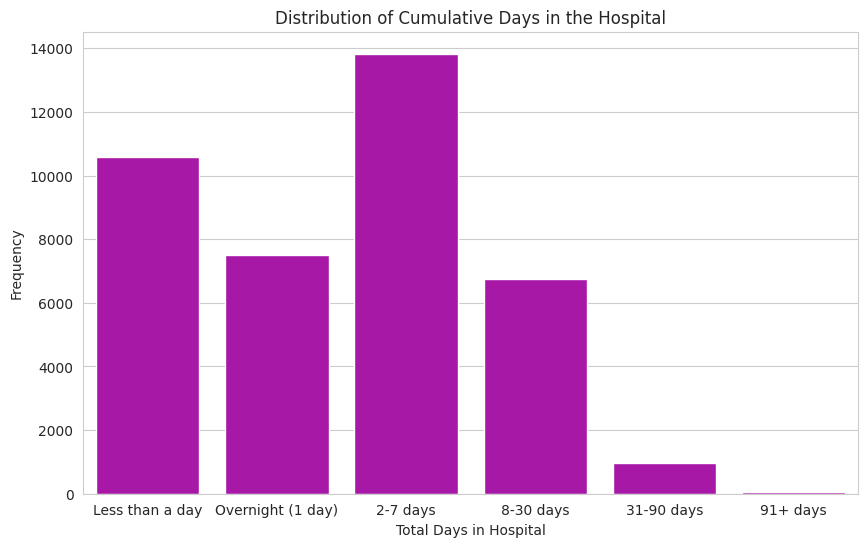

In [28]:
# plot a countplot of the bins
plt.figure(figsize=(10, 6))
sns.countplot(x=patients['length_of_stay_bin'], color="m")
plt.title('Distribution of Cumulative Days in the Hospital')
plt.xlabel('Total Days in Hospital')
plt.ylabel('Frequency')
plt.show()

The mean length of stay was 5.2 days. One patient was in the hospital for 215 days. Generally, the most patients stayed for one day or less.

## Question 12:
pandas, matplotlib, seaborn

For patients recieving inpatient surgery, is there a relationship between age and cumulative number of days in the hospital?

1. Add mean age column to the patients dataset.

2. Isolate patients who recieved inpatient surgery, and limit the sample to those who stayed in the hospital for less than 30 days.

3. Plot the relationship between age and days in hospital with a scatterplot.


<IPython.core.display.Javascript object>

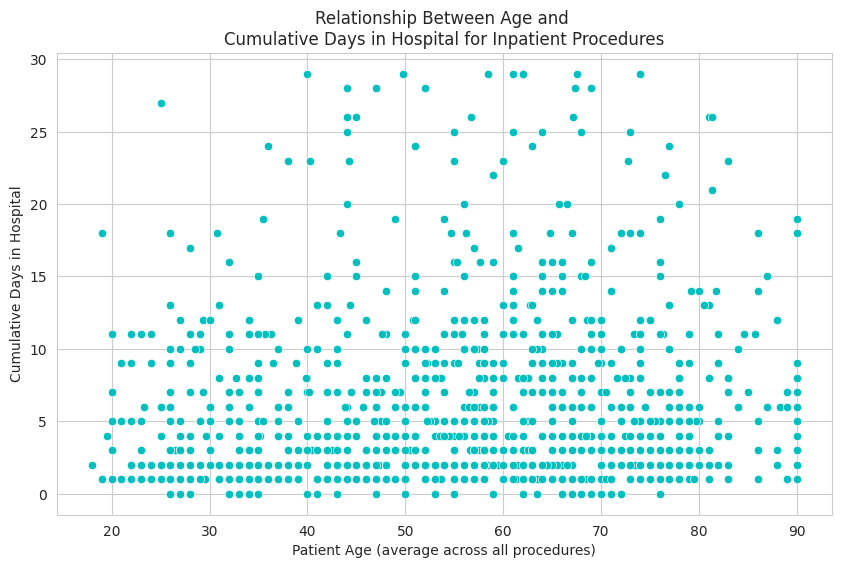

In [29]:
# create 'mean age' column
patients['mean_age'] = info.groupby('mrn')['age'].mean()

# isolate inpatients who stayed less than 30 days
inpatient = info[info['in_outpatient'] == 'Inpatient']['mrn'].to_list()
patients_inpatient = patients[patients.index.isin(inpatient)]
patients_inpatient = patients_inpatient[patients_inpatient['days_in_hospital'] < 30]

# scatter plot
patients_sample = patients_inpatient.sample(1000)

fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(data=patients_sample, x='mean_age', y='days_in_hospital', color='c')
ax.set_title('Relationship Between Age and \nCumulative Days in Hospital for Inpatient Procedures')
ax.set_xlabel('Patient Age (average across all procedures)')
ax.set_ylabel('Cumulative Days in Hospital')
plt.show()

There does not appear to be a relationship between age and days in the hospital.

## Question 13:
Pandas, numpy, seaborn, matplotlib

Is there a relationship between age and number of hospital visits?

What is the range of number of visits for the oldest and youngest patients? How old was the person who went to the hospital the most?

<IPython.core.display.Javascript object>

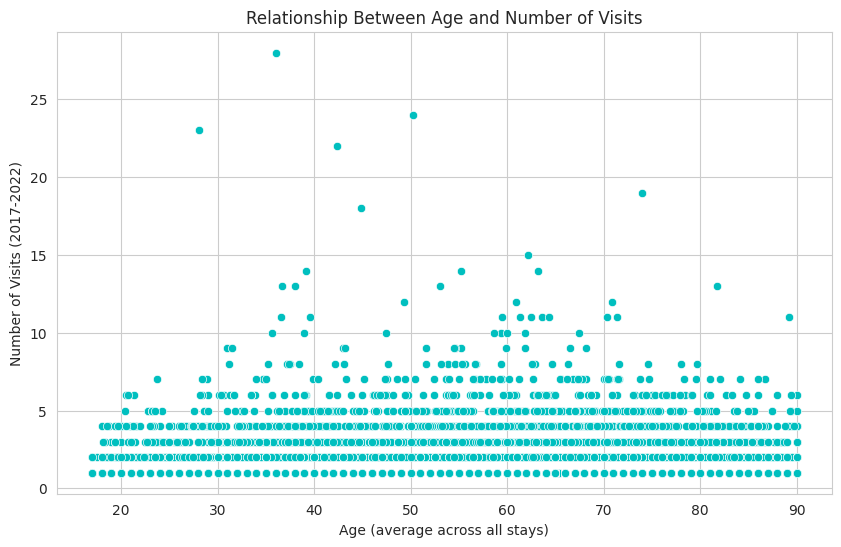

,1bb09d5761661c7d
procedures_count,41
visits_count,28
days_in_hospital,67.0
length_of_stay_bin,31-90 days
mean_age,36.0



The youngest recorded patients, at age 17.0, visited between 2 and 2 times between 2017-2022
The oldest recorded patients, at age 90.0, visited between 1 and 6 times between 2017-2022


In [30]:
sample = patients.sample(1000)

# plot scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=patients, x='mean_age', y='visits_count', color='c')
plt.title('Relationship Between Age and Number of Visits')
plt.xlabel('Age (average across all stays)')
plt.ylabel('Number of Visits (2017-2022)')
plt.show()

# patient with most visits
display(patients.loc[patients['visits_count'].idxmax()])
# youngest patients
youngest = patients[patients['mean_age'] == patients['mean_age'].min()]
print(f"\nThe youngest recorded patients, at age {np.mean(youngest['mean_age'])}, visited between "
      f"{np.max(youngest['visits_count'])} and {np.max(youngest['visits_count'])} times between 2017-2022")
#oldest patients
oldest = patients[patients['mean_age'] == patients['mean_age'].max()]
print(f"The oldest recorded patients, at age {np.mean(oldest['mean_age'])}, visited between "
      f"{np.min(oldest['visits_count'])} and {np.max(oldest['visits_count'])} times between 2017-2022")

There does not appear to be a strong relationship between age and number of visits to the hospital. The person who had the most stays within the time period (28), was 36 years old.

## Question 14:
pandas, matplotlib, seaborn

Does using the mean number of visits per age show more of a correlation with number of hospital visits? Plot the relationship using a scatterplot

<IPython.core.display.Javascript object>

,visits_count
age_floor,
17.0,1.130435
18.0,1.155844
19.0,1.139831
20.0,1.207018
21.0,1.182759
...,...
86.0,1.412844
87.0,1.320000
88.0,1.335484


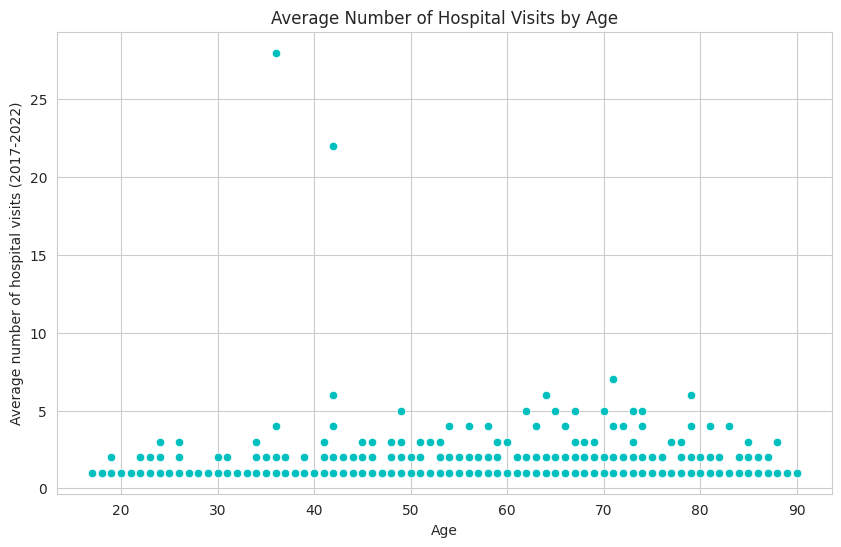

In [31]:
patients['age_floor'] = patients['mean_age'] // 1

age_visits = patients.groupby('age_floor')['visits_count'].mean()
age_visits.reset_index()
display(age_visits)

sample = patients.sample(1000)

# plot scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=sample, x='age_floor', y='visits_count', color='c')
plt.title('Average Number of Hospital Visits by Age')
plt.xlabel('Age')
plt.ylabel('Average number of hospital visits (2017-2022)')
plt.show()

Taking the average for each age does not show a relationship between age and number of hospital visits

## Question 15:
numpy, pandas, defined function, seaborn, matplotlib

How are the distributions of BMI different between male and female patients?

1. Define a function to convert height from feet and inches to inches
2. Create a bmi column
2. Use numpy to find the median, mean, and standard deviation of BMI by sex.
4. Plot histograms of the distribution of BMI by sex

In [32]:
# add sex to the patients dataframe
bmi_data = info[['mrn', 'sex', 'height_ft_in', 'weight_oz', 'age' , 'icu_admit']].copy()
bmi_data.set_index(['mrn'], inplace=True)
patients['sex'] = bmi_data.groupby('mrn').agg(sex=('sex', 'first'))
bmi_data.dropna(subset=['sex', 'height_ft_in', 'weight_oz'], inplace=True)

def ft_in_to_in(height: str) -> float:
  '''converts height in feet and inches into inches'''
  ft, inch = height.split("'")
  return float(ft) * 12 + float(inch)

# convert height, weight
bmi_data['height_in'] = bmi_data['height_ft_in'].apply(ft_in_to_in)
bmi_data['weight_lb'] = bmi_data['weight_oz'] / 16
bmi_data.drop(columns=['height_ft_in', 'weight_oz'], inplace=True)

# calculate bmi and add to patients dataframe
bmi_data['bmi'] = (bmi_data['weight_lb'] * 703) / (bmi_data['height_in'] ** 2)
sbmi_group = bmi_data.groupby('mrn').agg(height_mean=('height_in', 'mean'),
                                                      weight_mean=('weight_lb', 'mean'), bmi_mean=('bmi', 'mean'))
patients = patients.merge(sbmi_group, on='mrn', how='left')
display(patients[['sex', 'height_mean', 'weight_mean', 'bmi_mean']])

<IPython.core.display.Javascript object>

,sex,height_mean,weight_mean,bmi_mean
mrn,,,,
0000c7ccaa009343,Female,66.0,164.463125,26.542143
0000e45237d1fc96,Male,72.0,220.460000,29.896485
000181ce0ebf1e12,Male,NaN,NaN,NaN
00018b4d9acb258b,Male,74.0,218.035000,27.990980
00048d479a5b6da4,Male,66.0,140.763750,22.717382
...,...,...,...,...
fffa69866f26de8a,Female,59.0,159.833750,32.278979
fffb5d2e00cf670f,Female,65.0,224.208125,37.306109
fffc39a39b57eee7,Male,69.0,162.478750,23.991296


<IPython.core.display.Javascript object>

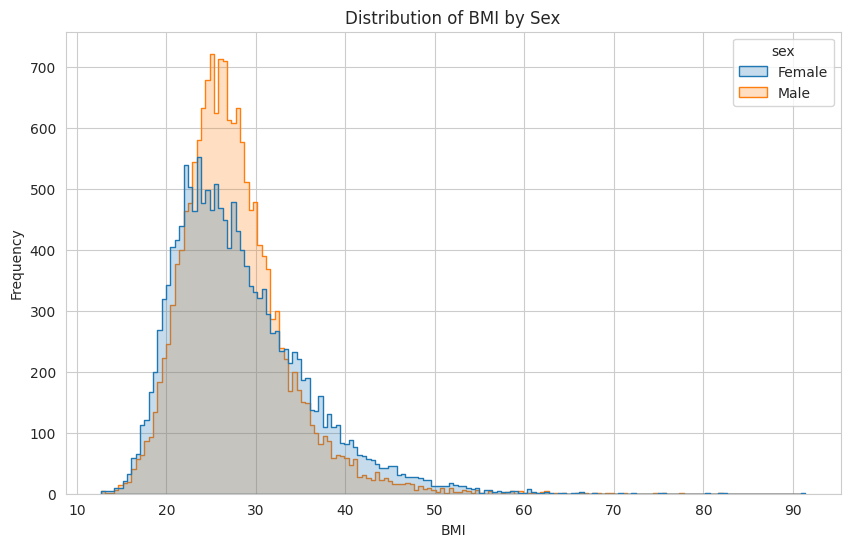

In [33]:
# plot histograms
bmi_plot = patients.dropna(subset=['bmi_mean', 'sex'])
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(data=bmi_plot, x='bmi_mean', hue='sex', element='step')
ax.set_title('Distribution of BMI by Sex')
ax.set_xlabel('BMI')
ax.set_ylabel('Frequency')
plt.show()

In [34]:
print(f'Median BMI for women: {np.median(bmi_plot[bmi_plot["sex"] == "Female"]["bmi_mean"])}')
print(f'Mean BMI for women: {np.mean(bmi_plot[bmi_plot["sex"] == "Female"]["bmi_mean"])}')
print(f'Standard deviation of BMI for women: {np.std(bmi_plot[bmi_plot["sex"] == "Female"]["bmi_mean"])}')

print(f'\nMedian BMI for men: {np.median(bmi_plot[bmi_plot["sex"] == "Male"]["bmi_mean"])}')
print(f'Mean BMI for men: {np.mean(bmi_plot[bmi_plot["sex"] == "Male"]["bmi_mean"])}')
print(f'Standard deviation of BMI for men: {np.std(bmi_plot[bmi_plot["sex"] == "Male"]["bmi_mean"])}')

<IPython.core.display.Javascript object>

Median BMI for women: 26.75569719042664
Mean BMI for women: 28.151008796771553
Standard deviation of BMI for women: 7.378458874621077

Median BMI for men: 26.689189694444444
Mean BMI for men: 27.545213152776913
Standard deviation of BMI for men: 5.912348425151726


Women in the dataset have a slightly larger distribution in BMI than men.

## Question 16:
pandas, defined function, matplotlib, seaborn

Does BMI affect the number of lab results that are abnormal?

1. Define a function that counts the number of abnormal labs per patient

2. Bin patient BMI into categories (underweight, obese, ect)

3. Plot the relationship with bar charts

In [ ]:
def label_counts(df, target_column, group_column, label_list):
  '''
  Counts the number of values in a target column of a data frame that match
  the labels in a list per entry in a user-specified groupby
  '''
  to_count = df[df[target_column].isin(label_list)]
  counts = to_count.groupby(group_column).size()
  return counts

patients['abnormal_labs'] = label_counts(labs, 'abnormal_result', 'mrn', ['H', 'L'])
patients['critical_labs'] = label_counts(labs, 'abnormal_result', 'mrn', ['HH', 'LL'])
patients.fillna({'abnormal_labs':0, 'critical_labs': 0}, inplace=True)
display(patients[['abnormal_labs', 'critical_labs']])

In [ ]:
# bin patients by bmi category
labels = ['Underweight', 'Normal', 'Overweight', 'Obese', 'Severely Obese']
bins = [0, 18.5, 25, 30, 40, 100]
patients['bmi_category'] = pd.cut(patients['bmi_mean'], bins=bins, labels=labels, right=False)

In [ ]:
# bar plots
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
sns.barplot(data=patients, x='bmi_category', y='abnormal_labs', estimator='mean', ax=ax[0], color="skyblue")
sns.barplot(data=patients, x='bmi_category', y='critical_labs', estimator='mean', ax=ax[1], color="salmon")
ax[0].set_title('Average Abnormal Lab Results by BMI Category')
ax[0].set_xlabel('BMI Category')
ax[0].set_ylabel('Average Number of Abnormal Lab Results')
ax[0].xaxis.set_tick_params(rotation=45)
ax[1].set_title('Average Critical Lab Results by BMI Category')
ax[1].set_xlabel('BMI Category')
ax[1].set_ylabel('Average Number of Critical Lab Results')
ax[1].xaxis.set_tick_params(rotation=45)
plt.tight_layout()
plt.show()

Underweight patients generally have the highest average number of lab results outside of the normal range, followed by those with a BMI over 40.

## Question 17:
numpy, pandas, seaborn, matplotlib

Can age or BMI be used to predict whether a patient will be admitted to the ICU? Plot a jointplot to examine the relationship.


In [ ]:
sample = bmi_data.sample(500)

jointplot = sns.jointplot(kind='scatter', data=sample, x='age', y='bmi', hue='icu_admit', palette='Set2')
jointplot.fig.suptitle('Relationship Between Age, BMI, and ICU Admission')
jointplot.set_axis_labels('Age', 'BMI')
plt.legend(title='ICU Admission')
plt.show()

In [ ]:
print(f'Average BMI for patients in ICU: {np.mean(bmi_data[bmi_data["icu_admit"] == "Yes"]["bmi"]) :.2f}')
print(f'Median BMI in the ICU: {np.median(bmi_data[bmi_data["icu_admit"] == "Yes"]["bmi"]) :.2f}')
print(f'Average age of patients in the ICU: {np.mean(bmi_data[bmi_data["icu_admit"] == "Yes"]["age"]) :.2f}')
print(f'Median age of patients in the ICU: {np.median(bmi_data[bmi_data["icu_admit"] == "Yes"]["age"]) :.2f}')

print(f'\nAverage BMI for patients not in ICU: {np.mean(bmi_data[bmi_data["icu_admit"] == "No"]["bmi"]) :.2f}')
print(f'Median BMI for patients not in ICU: {np.median(bmi_data[bmi_data["icu_admit"] == "No"]["bmi"]) :.2f}')
print(f'Average age of patients not in the ICU: {np.mean(bmi_data[bmi_data["icu_admit"] == "No"]["age"]) :.2f}')
print(f'Median age of patients not in the ICU: {np.median(bmi_data[bmi_data["icu_admit"] == "No"]["age"]) :.2f}')

There is not a particularly strong correlation between the three variables, though patients in the ICU have a very slightly greater mean age and BMI

## Question 18:
lambda functions, pandas, matplotlib

ICD-9 codes are used to classify diagnoses. There are seventeen main categories of illness or injury, as described in [IC9-data.com](https://www.icd9data.com/2015/Volume1/default.htm). What are the proportions of each of these categories among the conditions treated at the hospital?

In [ ]:
# isolate number-only diagnosis codes (codes containing supplemental infomation begin with E or V)
visit.dropna(subset=['diagnosis_code'], inplace=True)
visit['diagnosis_code'] = visit['diagnosis_code'].str.replace('.', '')
visit_nums = visit[visit['diagnosis_code'].str.isdigit()]
visit_nums.loc[:, 'diagnosis_code'] = visit_nums['diagnosis_code'].map(lambda x: x[0:3] + '.' + x[3:])

# convert diagnosis codes to floats
visit_nums.loc[:, 'diagnosis_code'] = visit_nums['diagnosis_code'].astype('float64')
visit_nums.set_index('mrn').sort_index()

In [ ]:
# map diagnoses by ICD-9 category
bins = [0, 140, 240, 280, 290, 320, 390, 460, 520, 580,
        630, 680, 710, 740, 760, 780, 800, 1000]
labels = ['Infectious/Parasitic Diseases', 'Neoplasms',
          'Endocrine, Nutritional, Metabolic', 'Blood/Blood-Forming Organs',
          'Mental Disorders', 'Nervous System/Sense Organs', 'Circulatory',
          'Respiratory', 'Digestive', 'Genitourinary', 'Pregnacy/Childbirth',
          'Skin/Subcutatous Tissue', 'Musculoskeletal', 'Congenital Anomalies',
          'Perinatal', 'Ill-Defined Conditions', 'Injury/Poisoning']
visit_nums.loc[:, 'condition_type'] = pd.cut(visit_nums['diagnosis_code'], bins=bins, labels=labels, right=False)
visit_nums.loc[:, 'condition_type'] = visit_nums['condition_type'].astype('object')
visit_nums.sort_values(by='mrn', inplace=True)
display(visit_nums)

In [ ]:
bar = visit_nums.groupby('condition_type').size().reset_index(name='count')
fig, ax = plt.subplots(figsize=(15, 10))
sns.barplot(data=bar, x='condition_type', y='count', hue='condition_type')
ax.set_title('Number of Conditions by Type')
ax.set_xlabel('Condition Type')
ax.set_ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
display(bar.sort_values(by='count', ascending=False)[0:5])

The most common conditions diagnosed during surgery-related hospital visits are circulatory conditions, genitournary condtions, neoplasms (cancers), digestive conditions, and injuries or poisonings.

## Question 19:
pandas

Which types of diagnoses increased the most in September?


In [ ]:
# merge dx and surgery info dataframes
month_dx = pd.merge(info, visit_nums, on=['mrn', 'log_id'], how='right')
month_dx['month'] = month_dx['surgery_date'].dt.month
to_pivot = month_dx.groupby(['condition_type', 'month']).size().to_frame('count').reset_index()

In [ ]:
pivot = to_pivot.pivot_table(index='condition_type', columns='month', fill_value=0)
pivot.head()

In [ ]:
# calculate deltas between months
pivot_delta = pivot.diff(axis=1)
pivot_delta = pivot_delta.fillna(0)
display(pivot_delta)

In [ ]:
pivot_delta = pivot_delta.reindex(pivot_delta['count'].sort_values(by=[9], ascending=False).index)
display(pivot_delta.iloc[0:5, 8])

## Question 20:
pandas

What percentage of procedures resulted in post-operative complications?



In [ ]:
complications = pd.read_csv('/content/drive/MyDrive/EPIC_EMR/EMR/patient_post_op_complications.csv')
complications.rename(columns={'MRN': 'mrn', 'LOG_ID': 'log_id', 'Element_abbr': 'kind'}, inplace=True)
complications.drop(columns=['Element_Name', 'CONTEXT_NAME', 'SMRTDTA_ELEM_VALUE'], inplace=True)
complications.head()

In [ ]:
to_merge = complications[complications['kind'] != 'AN Post-op Complications']
to_merge = to_merge.groupby(['mrn', 'log_id'])['kind'].apply(list).to_frame()
to_merge.reset_index(inplace=True)
to_merge['complications_count'] = to_merge['kind'].apply(lambda x: len(x))
to_merge['complications_kind'] = to_merge['kind'].apply(lambda x: list(set(x)))
to_merge.drop(columns=['kind'], inplace=True)

In [ ]:
info = pd.merge(info, to_merge, on=['mrn', 'log_id'], how='left')
info.fillna({'complications_count': 0, 'complications_kind': 'None'}, inplace=True)

In [ ]:
percent = len(info[info['complications_count'] > 0])/len(info) * 100
print(f'Percentage of patients with post_operative complications: {percent:.2f}%')

## Question 21
pandas, matplotlib, seaborn

Did male or female patients experience more post-op complications?

In [ ]:
comp_age = info.groupby('sex')['complications_count'].sum().to_frame()
comp_age.drop(index='Unknown', inplace=True)
comp_age.reset_index(inplace=True)
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(data=comp_age, x='sex', y='complications_count', color = 'turquoise')
plt.title('Number of Post-operative Complications by Sex')
plt.xlabel('Sex')
plt.ylabel('Number of Post-operative Complications')
plt.show()

## Question 22
pandas, matplotlib

Is there a relationship between BMI and whether or not a patient will experience complications?

1. Add a complications count to the patients dataset
2. Find the percentage of patients in each BMI category who experienced complications
3. Plot the relationship with a bar chart.

In [ ]:
# complications count to patients table
patients['complications_count'] = info.groupby('mrn')['complications_count'].sum()
patients.fillna({'complications_count': 0}, inplace=True)
# find percentages
bmi_comp = patients.groupby('bmi_category').size().to_frame('total_count')
bmi_comp['patients_with_complications'] = patients[patients['complications_count'] > 0].groupby('bmi_category').size()
bmi_comp['percent_with_complications'] = bmi_comp['patients_with_complications'] / bmi_comp['total_count'] * 100

#plot
plt.figure(figsize=(10, 6))
bmi_comp['percent_with_complications'].plot(kind='bar', color='forestgreen')
plt.title('Percentage of Patients with Complications by BMI Category')
plt.xlabel('BMI Category')
plt.ylabel('Percentage of Patients with Complications')
plt.xticks(rotation=45)
plt.show()

The percentage of patients with post-operative complications was between 2-4% for all BMI categories.

## Question 23:
self-defined function, numpy, matplotlib, pandas, seaborn

Does a patient's ASA rating affect how long they stay in the hospital?
1. Define a function for finding the interquartile range with numpy

2. Create a series of boxplots to visualize the relationship.

In [ ]:
asa_los = info[['mrn', 'hospital_admission', 'asa_rating', 'length_of_stay_days']].copy()
asa_los.dropna(subset=['asa_rating', 'length_of_stay_days'], inplace=True)

# avoid double counting by only including one entry per patient and hospital admission
g = asa_los.groupby(['mrn', 'hospital_admission']).agg(asa_max=('asa_rating', 'max'),
                                                      length_of_stay=('length_of_stay_days', 'mean'))
#add maximum asa to the patients table
patients['asa_max'] = g['asa_max'].groupby('mrn').max()
def iqr(series):
  q75, q25 = np.percentile(series, [75, 25])
  return q75, q25, q75 - q25

healthy = g[g['asa_max'] == 1]['length_of_stay']
mild = g[g['asa_max'] == 2]['length_of_stay']
severe = g[g['asa_max'] == 3]['length_of_stay']
incapacitating = g[g['asa_max'] == 4]['length_of_stay']
moribund = g[g['asa_max'] == 5]['length_of_stay']
brain_dead = g[g['asa_max'] == 6]['length_of_stay']

print(f'IQR for Patients Classified ASA 1: {iqr(healthy)[2]} days ({iqr(healthy)[1]} - {iqr(healthy)[0]})')
print(f'IQR for Patients Classified ASA 2: {iqr(mild)[2]} days ({iqr(mild)[1]} - {iqr(mild)[0]})')
print(f'IQR for Patients Classified ASA 3: {iqr(severe)[2]} days ({iqr(severe)[1]} - {iqr(severe)[0]})')
print(f'IQR for Patients Classified ASA 4: {iqr(incapacitating)[2]} days ({iqr(incapacitating)[1]} - {iqr(incapacitating)[0]})')
print(f'IQR for Patients Classified ASA 5: {iqr(moribund)[2]} days ({iqr(moribund)[1]} - {iqr(moribund)[0]})')
print(f'IQR for Patients Classified ASA 6: {iqr(brain_dead)[2]} days ({iqr(brain_dead)[1]} - {iqr(brain_dead)[0]})')

In [ ]:
# box and strip plots
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(data=g, x='length_of_stay', y='asa_max', hue='asa_max', orient='y', palette='Set2')
sns.stripplot(data=g, x='length_of_stay', y='asa_max', hue='asa_max',
              palette='Set2', legend=False, orient='y', linewidth=0.2)
ax.set_title('Relationship Between Maximum ASA Classification and Length of Stay')
ax.set_xlabel('Length of Stay (days)')
ax.set_ylabel('ASA Classification (maximum per stay)')
plt.xticks([0, 50, 100, 150, 200, 250])
plt.legend(labels=['1 - Healthy', '2 - Mild Systemic Disease', '3 - Severe Systemic Disease',
               '4 - Incapacitating Disease', '5 - Moribund', '6 - Brain Dead \n(organ retrieval)'])

plt.show()

It appears that both the IQR and total range of the length of hospital stays increases along with the severity of illness. Patients who are brain dead and in the hospital for organ retrieval generally do not stay long.

## Question 24:
pandas, matplotlib, seaborn

Does having a higher ASA rating lead to more complications?

In [ ]:
plt.figure(figsize=(10, 6))
no_6 = patients[patients['asa_max'] != 6]
sns.barplot(data=no_6, y='complications_count', palette='Set2', hue='asa_max',
            estimator='mean')
plt.title('Average Complications by ASA Rating')
plt.ylabel('Number of Complications')
plt.xlabel('ASA Classification')
plt.show()

## Question 25
pandas, seaborn

Generate a heatmap of all the numerical columns in the patients dataset. Which variables are most highly correlated with the number of days a patient stays in the hospital?

In [ ]:
patients_corr = patients.drop(columns=['length_of_stay_bin', 'sex', 'bmi_category'])
patients_corr.dropna(inplace=True)
patients

In [ ]:
patients_corr = patients_corr.corr()
patients_corr
plt.figure(figsize=(10, 6))
sns.heatmap(patients_corr, cmap='coolwarm', annot=True)
plt.show()

In [ ]:
# top 3 variables most highly correlated with time spent in the hospital
print(patients_corr['days_in_hospital'].sort_values(ascending=False).iloc[1:4])

The number of surgical procedures a patient recieves, and the number of abnormal and critical lab results is the most highly correlated with how long a patient will stay in the hospital.

In [ ]:
patients.info()

### Citations:

1. Samad M, Angel M, Rinehart J, Kanomata Y, Baldi P, Cannesson M. Medical Informatics Operating Room Vitals and Events Repository (MOVER): a public-access operating room database. JAMIA Open. 2023 Oct 17;6(4):ooad084. doi: 10.1093/jamiaopen/ooad084. PMID: 37860605; PMCID: PMC10582520
2. Farahmand, Maryam (2024). Class Modules. Introduction to Programming for Data Science (DS 5010). Northeastern University
3. numpy.org
4. pandas.pydata.org
5. seaborn.pydata.org
6. matplotlib.org
7. geeksforgeeks.org
8. stackoverflow.com